In [30]:
import pandas as pd

df = pd.read_csv("../data/raw_analyst_ratings.csv", index_col=0)  
print(df.head())
print(df.columns)

                                            headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:0

In [11]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB
None
(1407328, 5)


In [12]:
print(type(df['headline']))
print(df['headline'].head())

<class 'pandas.core.series.Series'>
0              Stocks That Hit 52-Week Highs On Friday
1           Stocks That Hit 52-Week Highs On Wednesday
2                        71 Biggest Movers From Friday
3         46 Stocks Moving In Friday's Mid-Day Session
4    B of A Securities Maintains Neutral on Agilent...
Name: headline, dtype: object


In [13]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(df.isnull().sum())

# We focus on the 'headline' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
df.dropna(subset=['headline'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null headlines: {df.shape[0]}")


--- 1. Null Value Check (Before Cleaning) ---
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null headlines: 1407328


📐 2. Descriptive Statistics

🔸 Headline Length

In [2]:
df["headline_length"] = df["headline"].astype(str).apply(len)
df["headline_length"].describe()


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

🔸 Count Articles per Publisher

<Axes: title={'center': 'Top 10 Publishers by Article Count'}, xlabel='publisher'>

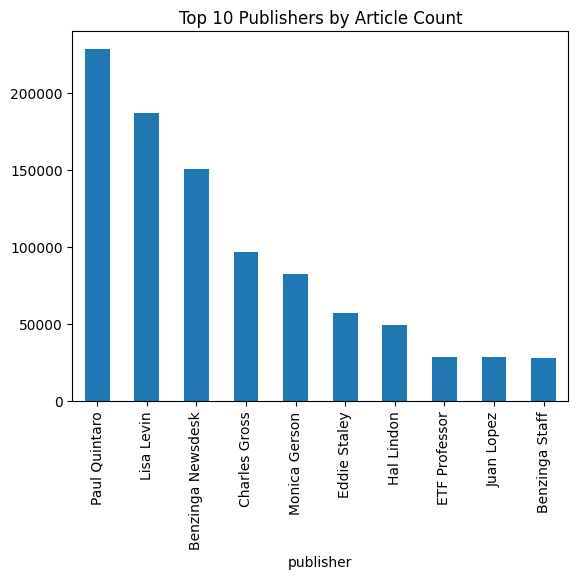

In [3]:
publisher_counts = df["publisher"].value_counts()
publisher_counts
top_publishers = publisher_counts.head(10)
top_publishers.plot(kind="bar", title="Top 10 Publishers by Article Count")

🔸 Publication Date Trends 

In [14]:
# --- 3. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    df.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {df.shape[0]}")

# Ensure the 'headline' column is string type before analysis
df['headline'] = df['headline'].astype(str)


Total duplicate rows found: 1
Rows remaining after dropping duplicates: 1407327


In [15]:
# --- 2. Date Structure and Time Series Preparation  ---

if 'date' in df.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    # Setting utc=True handles the mixed timezone offsets by normalizing all values to UTC 
    # and ensures the resulting column is a proper datetime dtype.
    df['date'] = pd.to_datetime(df['date'], format='ISO8601', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(df['date'].head())
    print(f"Data type is now: {df['date'].dtype}")

    # 2. Set the Index
    # Note: Since utc=True was used, the dates are already in UTC.
    df.set_index('date', inplace=True)
    print("\nDataFrame Index is now set to Date (UTC).")
    print(df.head()) 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")


--- 2. Date Column Structure (After Conversion) ---
0   2020-06-05 14:30:54+00:00
1   2020-06-03 14:45:20+00:00
2   2020-05-26 08:30:07+00:00
3   2020-05-22 16:45:06+00:00
4   2020-05-22 15:38:59+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]

DataFrame Index is now set to Date (UTC).
                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   

                                                                         url  \
date                                

In [18]:
sample = df.head(100)

🧠 3. Text Analysis — Topic Modeling

In [19]:


from textblob import TextBlob

sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)
print(sample[['headline','TextBlob_Sentiment','TextBlob_Category']])



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   
...                                                                      ...   
2019-10-09 04:00:00+00:00  Barclays Maintains Equal-Weight on Agilent Tec...   
2019-10-08 04:00:00+00:00  Shares of several healthcare companies are tra...   
2019-10-02 04:00:00+00:00  Shares of several healthcare companies are tra...   
2019-09-05 04:00:00+00:00  Shares of several healthcar

C:\Users\PC\AppData\Local\Temp\ipykernel_4276\4177660900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Sentiment'] = sample['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
C:\Users\PC\AppData\Local\Temp\ipykernel_4276\4177660900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)


C:\Users\PC\AppData\Local\Temp\ipykernel_4276\4163120699.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


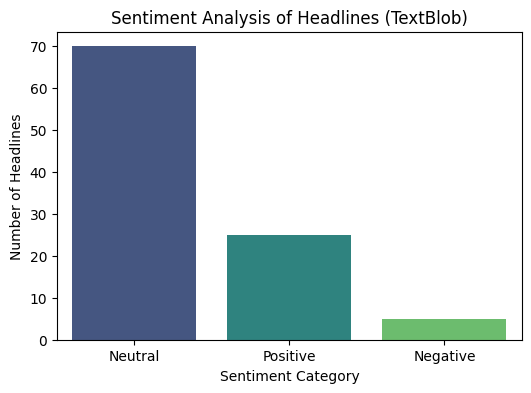

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_counts = sample['TextBlob_Category'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Analysis of Headlines (TextBlob)")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Category")
plt.show()

⏳ 4. Time Series Analysis

🔸 Publication Frequency Over Time

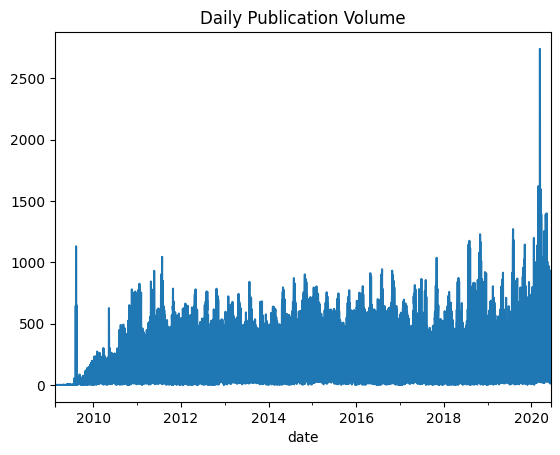

In [21]:
if 'published_at' in df.columns:
	# ensure 'published_at' is datetime (coerce errors to NaT) and normalize to UTC
	df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', utc=True)

	# drop rows with missing published_at to avoid NaT-related errors, then resample
	temp = df.dropna(subset=['published_at']).set_index('published_at')
	temp.resample('D').size().plot(title="Daily Publication Volume")
else:
	# fallback: use existing datetime index if available
	df.resample("D").size().plot(title="Daily Publication Volume")


🔸 Publishing Hour Pattern

<Axes: xlabel='hour'>

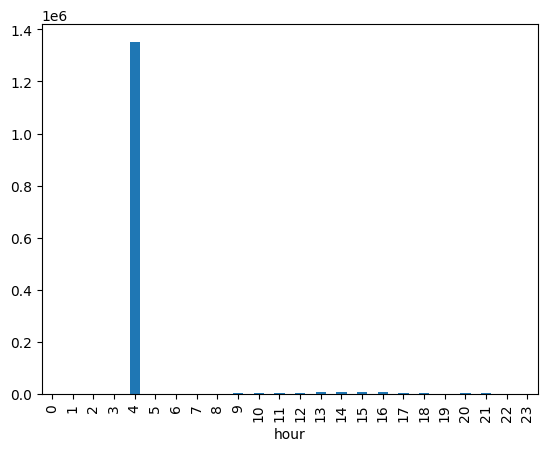

In [23]:
# Extract hour from 'published_at' when available, otherwise use the DatetimeIndex
if 'published_at' in df.columns:
	# ensure datetime dtype (coerce errors) and normalize to UTC to be safe
	df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', utc=True)
	df['hour'] = df['published_at'].dt.hour
else:
	# the DataFrame index is already a DatetimeIndex (set earlier), so use it
	df['hour'] = df.index.hour

# Plot hourly publication distribution
df['hour'].value_counts().sort_index().plot(kind="bar")

📰 5. Publisher Analysis

In [24]:
import re

def get_domain(x):
    match = re.search("@(.+)", str(x))
    return match.group(1) if match else "unknown"

df["publisher_domain"] = df["publisher"].apply(get_domain)

df["publisher_domain"].value_counts()


publisher_domain
unknown                   1399239
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64